In [78]:
import os, pathlib;
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


directory = os.getcwd()
p = pathlib.Path(directory)
parentDir= str(p.parents[0])

filepath = parentDir #+ "/DataFiles/" 
csvName = "UTD_LP_File_1.csv"
pickleName = "UTD_LP_File_1.pick"
#df_csv = pd.read_csv(csvName) #filepath + 
df = pd.read_pickle(pickleName) #filepath +
#display(df.head())
#df.describe()

[24 24 30 30]


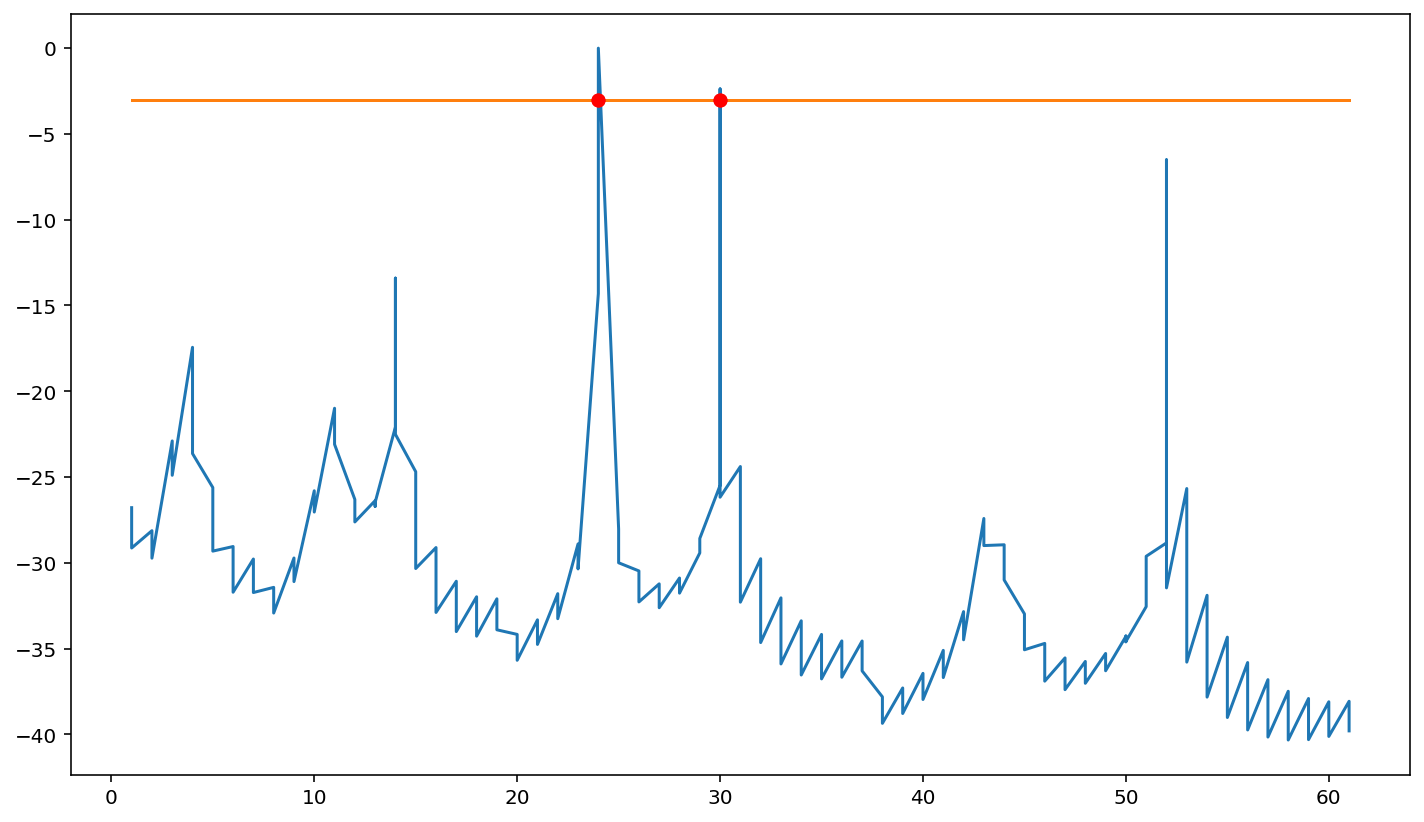

In [79]:
df_harm1 = df[df['harmonic']==1]
df_harm1 = df_harm1[['gammaTuple', 'power', 'Pin', 'Pout', 'Gain', 'PAE', 'drainEff', 'r', 'x']].copy()

#PANDAS is a package that helps with analyzing data.
#below, df.set_index is being used to set a dataframe"(df)"".
#parameters definitions: 
#key =used to select the column of gammaTuple
#drop=boolean value which drops the column used column if false
#inplace=make changes to dataframe"(df)" if true.

df.set_index(keys=['gammaTuple'], drop=False,inplace=True)
uniqGammas=df['gammaTuple'].unique().tolist() #from our dataframe we list the unique values of gammaTuple then convert the series of values to a list. 

maxGain = max(df_harm1['Gain'].to_numpy().transpose().tolist()) #find max Gain in df


df_harm1['gComp'] = df_harm1['Gain'] - maxGain #gComp=Gain-maxGain
#print(maxGain)
#display(df_harm1['gComp'].describe())
#print(uniqGammas)

g1 = []
for i, row in df_harm1.iterrows():
    gT = row['gammaTuple']
    g1.append(gT[0])

df_harm1['gamma1'] = g1

print(df_harm1['gamma1'][0])

listGamDf = []

for gam in uniqGammas:
    gamDf = df_harm1.loc[df_harm1.gammaTuple==gam]
    gamDf.index = range(len(gamDf))
    listGamDf.append(gamDf)


x = df_harm1['gamma1'].to_numpy().transpose()
f = df_harm1['gComp'].to_numpy().transpose()
l = np.array([-3]*len(x))
plt.plot(x, f, '-')
plt.plot(x,l,'-')
idx = np.argwhere(np.diff(np.sign(f - l))).flatten()
plt.plot(x[idx], l[idx], 'ro')
print(x[idx])
plt.show()

In [80]:
'''
rectangular plot for ever gamma tuple x= r y = x z= variable - 3d surface plot/contours
gComp = gain - maxGain (constant slice at -3dB)

#generate col named  'gain' - df.max('gain')

linear gain = gcomp = gain - gain(1)
drop down for selection of the variable to slice and plot (pout, gain, pae etc.)
'''
pass

In [84]:
import statistics
import plotly.graph_objects as go

colList = df_harm1.columns

dfOfLoadsAtVarX = pd.DataFrame()

#
#def plot()
#
def pickZvalAndPlot(z):
    print("I'll plot r and x vs.", z)
    display(dfOfLoadsAtVarX)
    
    

    '''
    df['r'] = dfOfLoadsAtPoutX[['r']].to_numpy().transpose().tolist()[0]
    df['x'] = dfOfLoadsAtPoutX[['x']].to_numpy().transpose().tolist()[0]  #np.dfOfLoadsAtPoutX['PAE'].transpose().tolist() 
    df['PAE'] = dfOfLoadsAtPoutX[['PAE']].to_numpy().transpose().tolist()[0]
    '''
    
    
    '''
    df =  dfOfLoadsAtVarX[['r','x','drainEff']].copy()
    df2 =  dfOfLoadsAtVarX[['r','x','PAE']].copy()
    
    fig3 = go.Figure(data=[go.Surface(z=df2.values)])
    fig3.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    fig3.update_layout(title='3D PAE with contour', autosize=False,
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90)
                      )
    fig3.update_layout(
            scene = {
                "xaxis": {"nticks": 20},
                "zaxis": {"nticks": 4},
                'camera_eye': {"x": 1.25, "y": -1.25, "z": 1.25},
            })
    fig3.show()
    '''



def pickVariable(selectedVariable):
    #minVal = 0
    #maxVal = 20
    #stepSize = 0.1
    #defaultVal = 10
    selVarList = df_harm1[selectedVariable].to_numpy().transpose().tolist()
    maxVal = max(selVarList)
    minVal = min(selVarList)
    stepSize = max((maxVal-minVal)/100, 0.1)
    defaultVal = statistics.median(selVarList)

    def interpolated_slice_var(x):
        listGamDfC = listGamDf.copy()
        CONST_VAL = x #x is the value from the slider value user chooses
        global dfOfLoadsAtVarX
        dfOfLoadsAtVarX = pd.DataFrame()

        cols = listGamDfC[-1].columns.to_list()
        cols.remove(selectedVariable)
        cols.remove('gammaTuple')

        for i,gamDf in enumerate(listGamDfC):
            calcDict = {}
            poutList = gamDf[[selectedVariable]].to_numpy().transpose().tolist()[0]
            for col in cols:
                colVals = gamDf[[col]].to_numpy().transpose().tolist()[0]
                calcVal = np.interp(CONST_VAL, poutList, colVals)
                #calcVal = barycentric_interpolate(poutList, colVals, FIXED_POUT)
                calcDict[col] = round(float(calcVal),6)
            calcDict[selectedVariable] = CONST_VAL
            calcDict['gammaTuple'] = gamDf['gammaTuple'][0]
            dfOfLoadsAtVarX = dfOfLoadsAtVarX.append(calcDict, ignore_index=True)
            listGamDfC[i] = gamDf.append(calcDict, ignore_index=True).sort_values(by=['power'],ignore_index=True)

        dfOfLoadsAtVarX = dfOfLoadsAtVarX.sort_values(by=['gammaTuple'],ignore_index=True)
    interact_manual(interpolated_slice_var, x=widgets.FloatSlider(min=minVal, max=maxVal, step=stepSize, value=defaultVal));
    selList = set(colList) - {selectedVariable, 'r', 'x'}
    interact_manual(pickZvalAndPlot, z=selList) #
    
interact(pickVariable, selectedVariable=['Pout','Gain','PAE'])

interactive(children=(Dropdown(description='selectedVariable', options=('Pout', 'Gain', 'PAE'), value='Pout'),…

<function __main__.pickVariable(selectedVariable)>

In [86]:
import plotly.graph_objects as go
import plotly.express as px
import plotly



df_3d =  dfOfLoadsAtVarX[['r','x','PAE']].copy()
coords = df_3d[['r', 'x', 'PAE']].values


fig = go.Figure({"data":[go.Surface(x=df_3d['x'].values,y=df_3d['r'].values,z=df_3d[['x','r','PAE']].values)], "layout":plotly.graph_objs.Layout(title='Some data', autosize=False,width=500, height=500,scene = dict(xaxis_title='x',yaxis_title='r',zaxis_title='x, r, PAE'),margin=dict(l=15, r=10, b=15, t=90))})

fig.show()



#---------------------------------------
#def surfacePlot(Spliced_Df):
 
df =  dfOfLoadsAtVarX[['r','x','drainEff']].copy()
df2 =  dfOfLoadsAtVarX[['r','x','PAE']].copy()

'''
df['r'] = dfOfLoadsAtPoutX[['r']].to_numpy().transpose().tolist()[0]
df['x'] = dfOfLoadsAtPoutX[['x']].to_numpy().transpose().tolist()[0]  #np.dfOfLoadsAtPoutX['PAE'].transpose().tolist() 
df['PAE'] = dfOfLoadsAtPoutX[['PAE']].to_numpy().transpose().tolist()[0]
'''

fig = go.Figure(data=[go.Surface(z=df.values)])

fig.update_layout(title='3D Drain Effeciency', autosize=False,
                  width=500, height=500)

fig.show()

#------------------------------------------
fig = go.Figure(data=[go.Surface(z=df2.values)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='3D PAE with contour', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
                  )
fig.update_layout(
        scene = {
            "xaxis": {"nticks": 20},
            "zaxis": {"nticks": 4},
            'camera_eye': {"x": 1.25, "y": -1.25, "z": 1.25},
        })

fig.show()


In [87]:
fig2 = px.scatter(dfOfLoadsAtVarX, x='r', y='x', color='PAE', height=600, width=600) # color='PAE'
fig = go.Figure(data =
    go.Contour(
        z= dfOfLoadsAtVarX['PAE'],
        x= dfOfLoadsAtVarX['r'], # horizontal axis
        y= dfOfLoadsAtVarX['x'], # vertical axis
        line_smoothing=1.3
    ))

fig.update_layout(height=700, width=700)
fig.show()
fig2.show()

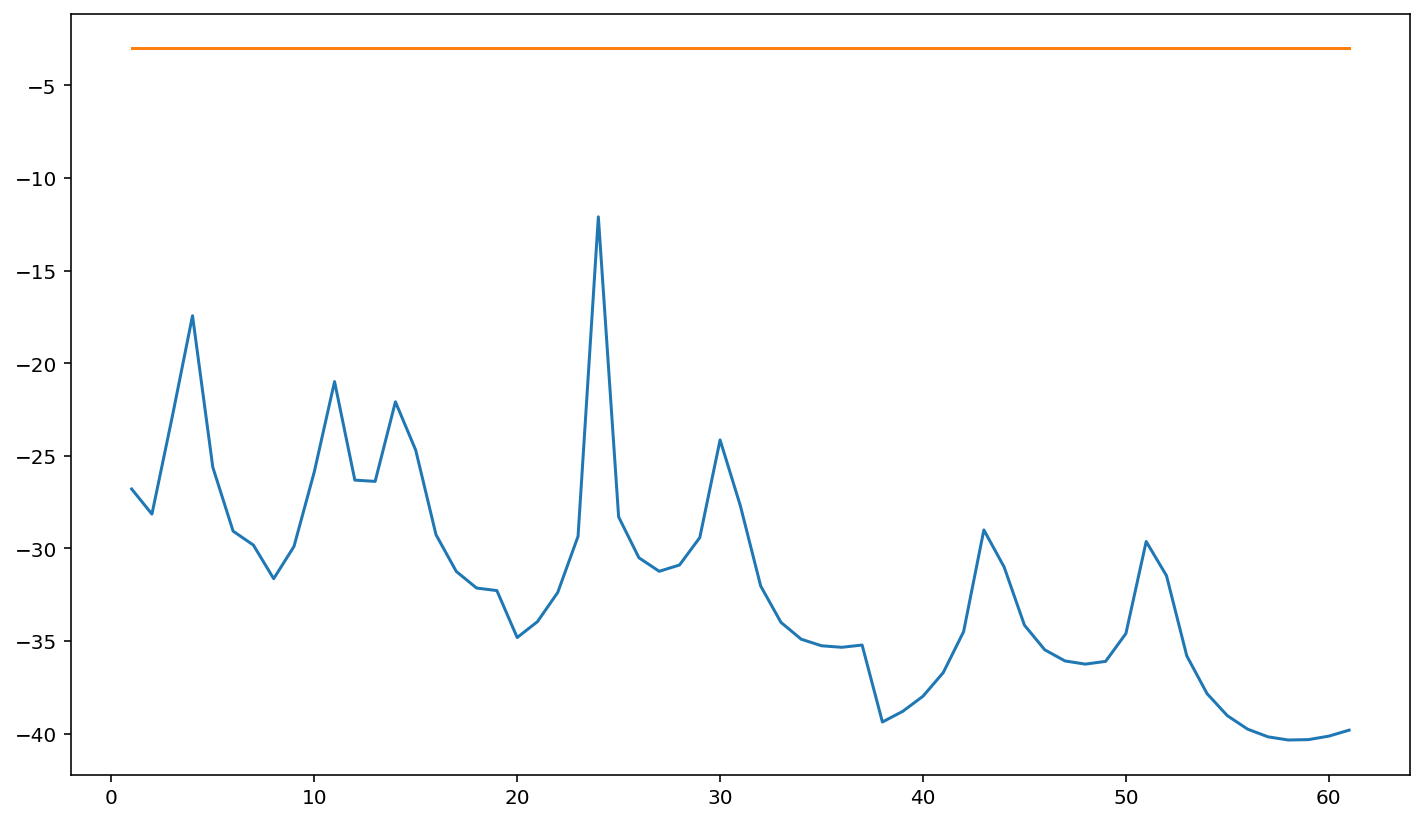

In [88]:
COMPRESSION_VAL = -3


x = dfOfLoadsAtVarX['gamma1'].to_numpy().transpose()
f = dfOfLoadsAtVarX['gComp'].to_numpy().transpose()
l = np.array([COMPRESSION_VAL]*len(x))
plt.plot(x, f, '-')
plt.plot(x,l,'-')
idx = np.argwhere(np.diff(np.sign(f - l))).flatten()
plt.plot(x[idx], l[idx], 'ro')
intersectionPoints = x[idx]
plt.show()

In [66]:
dfOfLoadsAtVarX = dfOfLoadsAtVarX[dfOfLoadsAtVarX['gamma1']>intersectionPoints[0]]
#display(dfOfLoadsAtVarX)

In [89]:
fig2 = px.scatter(dfOfLoadsAtVarX, x='r', y='x', color='PAE', height=600, width=600) # color='PAE'
fig = go.Figure(data =
    go.Contour(
        z= dfOfLoadsAtVarX['PAE'],
        x= dfOfLoadsAtVarX['r'], # horizontal axis
        y= dfOfLoadsAtVarX['x'], # vertical axis
        line_smoothing=1.3
    ))

fig.update_layout(height=700, width=700)
fig.show()
fig2.show()